In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler

In [51]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
LABELLED_OUTLIERS = os.path.join(DATA_FOLDER, 'outliers_labelled.csv')
OUTLIERS_REMOVED = os.path.join(DATA_FOLDER, "outliers_removed.csv")

In [52]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

True
True


## Preliminary

In [53]:
# Redefine some stuff of used OD classes
# to obtain code continuity
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

class MyLOF(LocalOutlierFactor):
    name = "LOF"

    @property
    def scores(self): return self.negative_outlier_factor_

class MyABOD(ABOD):
    name = "ABOD"

    @property
    def scores(self): return self.decision_scores_

class MyISFO(IsolationForest):
    name = "ISFO"

    def fit(self, X):
        self._train_samp = X
        return super().fit(X)
    
    @property
    def scores(self): return self.score_samples(self._train_samp)

## FInd outliers

For each method finds the top `p%` outliers

In [54]:
p = 0.02

methods = [MyLOF, MyABOD, MyISFO]
params = [dict(n_jobs=-1), dict(), dict(n_jobs=-1, n_estimators=100)] # Parameters of the estimators

# The sub-samples in which the dataset is divided
# Currently the OD is performed on each element of (vocal_channel, sex) product category
locality_areas = []
for vc in ["song", "speech"]:
    for s in ["M","F"]:
        locality_areas.append(dict(vocal_channel=vc, sex=s))

for meth, pars in zip(methods, params):
    # Initializes each record not to be an outlier
    df[f"is_{meth.name}_outlier"] = False 
    for locality in locality_areas:
        locality_mask = np.array([(df[key] == val).values for key, val in locality.items()]).all(axis=0)
        N_p = int(p*np.sum(locality_mask))
        print(f"{meth.name}: Taking {N_p} outliers for locality {list(locality.keys())} = {list(locality.values())}", end="")

        subsamp = MinMaxScaler().fit_transform( df.loc[locality_mask][numerical_attr_list].values )
        outlier_detector = meth(**pars)
        outlier_detector.fit(subsamp)
        df.loc[locality_mask, f"{meth.name}_score"] = outlier_detector.scores

        # Takes the worsts
        bad_kids = df.loc[locality_mask, f"{meth.name}_score"].nsmallest(N_p).index
        print(f" --> {bad_kids.values}")
        # Set them to be outliers
        df.loc[bad_kids,f"is_{meth.name}_outlier"] = True

df["outlier_color"] = "k"
code_map = dict(not_outlier="k", ABOD="g", LOF="r", ISFO="b")
for meth in methods:
    df.loc[df[f"is_{meth.name}_outlier"], "outlier_color"] = code_map[meth.name]


LOF: Taking 10 outliers for locality ['vocal_channel', 'sex'] = ['song', 'M'] --> [ 698  927 1738 1757 1765 2304 1759  484 1756 1758]
LOF: Taking 9 outliers for locality ['vocal_channel', 'sex'] = ['song', 'F'] --> [ 382  589 2210 1206 1421 1241 1204 1240 1239]
LOF: Taking 14 outliers for locality ['vocal_channel', 'sex'] = ['speech', 'M'] --> [ 832  841 1296  878 1481    0 2248  425 1877 1704  633 2282 2291 1480]
LOF: Taking 14 outliers for locality ['vocal_channel', 'sex'] = ['speech', 'F'] --> [1969 2392 1968 2375 1160 2383 1177 1982  544  546  352 1964 1818  755]
ABOD: Taking 10 outliers for locality ['vocal_channel', 'sex'] = ['song', 'M'] --> [2101 1319 1110 2105 2109 2111 2100 1335 2097 2099]
ABOD: Taking 9 outliers for locality ['vocal_channel', 'sex'] = ['song', 'F'] --> [1634 1635  788 2238 1994 1995 2015 1639 1640]
ABOD: Taking 14 outliers for locality ['vocal_channel', 'sex'] = ['speech', 'M'] --> [1251 1249 1302 1248 1250 1258 1478 1666 1257 1068 1262 1078 1279 1261]
ABOD:

Now check whether the outliers have a predominant category

Text(0.5, 0.98, 'Category of outliers for each method')

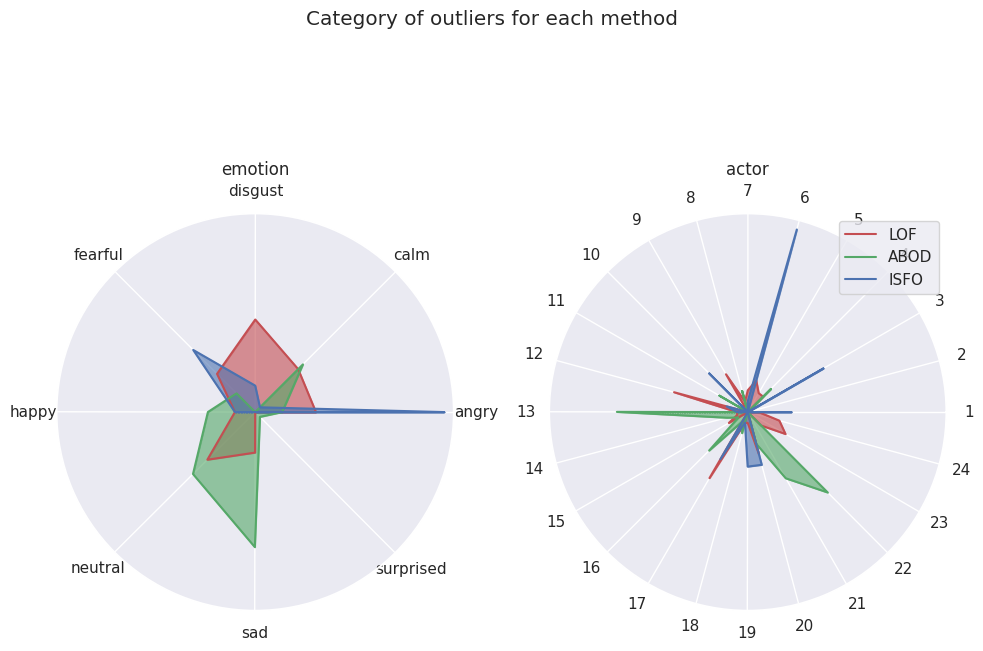

In [55]:
def plot_polar_closed(items, r, ax, **kwargs):
    items = list(items)
    asort = np.argsort(items)

    items = np.array(items)[asort]
    r = np.array(list(r))[asort]

    theta = np.linspace(0, 6.28, len(items), endpoint=False)

    theta = np.append(theta, theta[0])
    r = np.append(r, r[0])
    fill_kwargs = kwargs.copy()
    fill_kwargs["alpha"] = 0.6,
    fill_kwargs["label"] = ""

    ax.fill_between(theta,0*r, r, **fill_kwargs)
    ax.plot(theta, r, **kwargs)

    ax.set_xticks(theta[:-1], items)
    ax.set_rticks([])

fig, axes = plt.subplots(1,2, figsize=(10,8), subplot_kw={'projection': 'polar'})
for i, cat in enumerate(["emotion", "actor"]):
    cat_vals, cat_counts = np.unique(df[cat], return_counts=True)
    if cat =="actor":
        cat_vals = [int(act_name.split("_")[1]) for act_name in cat_vals]
    cat_counts = cat_counts/np.sum(cat_counts)

    for meth in methods:
        outlying_items, counts_num = np.unique(df.loc[df[f"is_{ meth.name}_outlier"], cat], return_counts=True)
        counts_num = counts_num/np.sum(counts_num)
        if cat == "actor":
            outlying_items = [int(act_name.split("_")[1]) for act_name in outlying_items]

        counts = {c:0 for c in np.unique(cat_vals)}
        for outlying_item, out_count, cc in zip(outlying_items, counts_num, cat_counts):
            # Normalize on category count
            # e.g.: More values of fear --> more outliers of fear
            counts[outlying_item] = out_count/cc

        plot_polar_closed(counts.keys(), counts.values(), axes[i], label=meth.name, color=code_map[meth.name])

axes[i].legend()
axes[0].set_title("emotion");
axes[1].set_title("actor");
plt.gcf().suptitle("Category of outliers for each method")

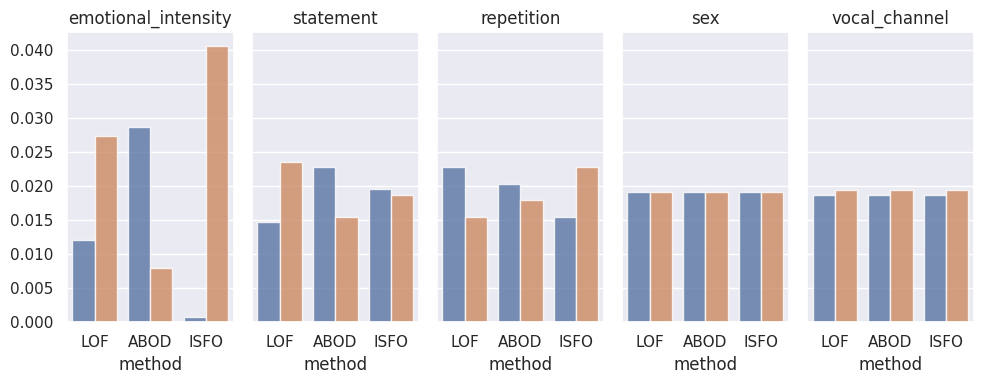

In [56]:
binary_categories = ["emotional_intensity",  "statement", "repetition", "sex", "vocal_channel",]
fig, axes = plt.subplots(1, len(binary_categories), figsize=(10, 4), sharey=True)
for cat, ax in zip(binary_categories, axes):
    small_df = pd.DataFrame()
    for meth in methods:
        o_values, o_counts = np.unique(df.loc[df[f"is_{meth.name}_outlier"], cat], return_counts = True)
        a_values, a_counts = np.unique(df[cat], return_counts = True)
        small_df = pd.concat([small_df, pd.DataFrame(dict(  method=[meth.name]*len(a_values), 
                                                            cat=cat,
                                                            rel_counts=o_counts/a_counts,
                                                            attr=a_values))])
        
    obj = sns.barplot(data=small_df,  x="method", y="rel_counts", ax=ax, hue="attr", alpha=0.8)
    ax.legend([], [], frameon=False)
    ax.set_title(cat)
    ax.set_ylabel("")
plt.tight_layout()

As it was expected, for sex and vocal channel the number of outliers for each value of the categorical attribute is approximately equal (by construction).
Emotional intensity is the most unbalanced categorical attribute, since one value of the categorical attribute is mostly categorized as outlier

## Check into an embedding

In [57]:
from sklearn.manifold import Isomap
from umap import UMAP
reducer = UMAP(n_components=2, n_neighbors=100)
embedding = reducer.fit_transform(MinMaxScaler().fit_transform(df[numerical_attr_list]))

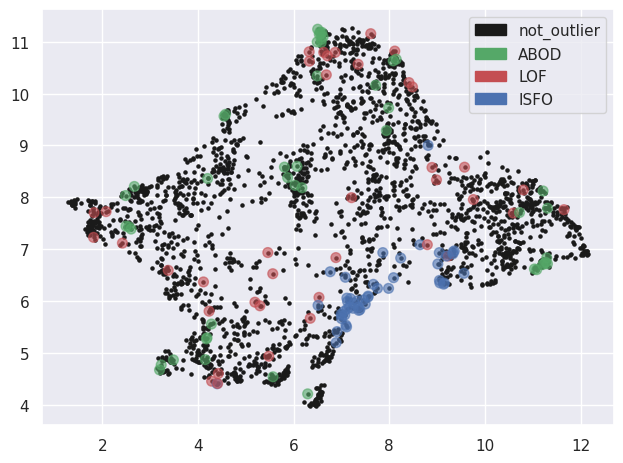

In [58]:
plt.scatter(*embedding.T, color="k", s=5)
plt.scatter(*(embedding[df.outlier_color != "k"]).T, c=df.outlier_color[df.outlier_color != "k"], alpha=0.6, s=50)

from matplotlib.patches import Patch
leg_handles, leg_lab = [], []
for k,v in code_map.items():
    leg_handles.append(Patch(color=v))
    leg_lab.append(k)
plt.legend(leg_handles, leg_lab);

The blue region (ISFO outliers) prevalently belongs to anger. That region is much less dense than the others, but UMAP is built to consder the multidimensional manifold to be uniform, so it maps them in a mostly uniform region of space of the embedding.

## TEST: OD Aggregation

In [63]:
df_bag = df.copy()
print(len(df_bag))

2452


In [64]:
# Redefine some stuff of used OD classes
# to obtain code continuity
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

class AggregatedOD(object):
    name = "aggregatedOD"
    def __init__(self, coefficient_vector=None, **pars):
        self.methods = []
        if coefficient_vector is None:
            coefficient_vector = np.ones(3)/3
        else:
            self.coefficient_vector = np.array(coefficient_vector)/np.sum(coefficient_vector)

        for od_meth in [MyISFO, MyABOD, MyLOF]:
            self.methods.append(od_meth(** (pars.get(od_meth.name, dict() ))))

    def fit(self, X):
        for od_meth in self.methods:
            od_meth.fit(X)

    @property
    def scores(self):
        self.single_scores = [MinMaxScaler().fit_transform(od_meth.scores.reshape(-1,1)).reshape(-1) for od_meth in self.methods]
        self.single_scores = np.array(self.single_scores)
        return self.coefficient_vector[None, :].dot(self.single_scores).reshape(-1)

In [65]:
p = 0.01

params = dict(ISFO=dict(n_jobs=-1, n_estimators=100),
              ABOD=dict(),
              LOF=dict(n_jobs=-1), ) # Parameters of the estimators

meth = AggregatedOD
outlier_detector = meth(coefficient_vector=[0.3, 1,1], 
                        **params)

# Initializes each record not to be an outlier
df_bag[f"is_{meth.name}_outlier"] = False
df_bag[f"{meth.name}_score"] = 70

for locality in locality_areas:
    locality_mask = np.array([(df_bag[key] == val).values for key, val in locality.items()]).all(axis=0)
    N_p = int(p*np.sum(locality_mask))
    print(f"{meth.name}: Taking {N_p} outliers for locality {list(locality.keys())} = {list(locality.values())}", end="")

    subsamp = MinMaxScaler().fit_transform( df_bag.loc[locality_mask][numerical_attr_list].values )
    outlier_detector.fit(subsamp)
    df_bag.loc[locality_mask, f"{meth.name}_score"] = outlier_detector.scores
    for m,s in zip(outlier_detector.methods, outlier_detector.single_scores):
        df_bag.loc[locality_mask, f"{m.name}_score"] = s


    # Takes the worsts
    bad_kids = df_bag.loc[locality_mask, f"{meth.name}_score"].nsmallest(N_p).index
    print(f" --> {bad_kids.values}")
    # Set them to be outliers
    df_bag.loc[bad_kids,f"is_{meth.name}_outlier"] = True


aggregatedOD: Taking 5 outliers for locality ['vocal_channel', 'sex'] = ['song', 'M'] --> [ 698  927 2101 1757 1110]
aggregatedOD: Taking 4 outliers for locality ['vocal_channel', 'sex'] = ['song', 'F'] --> [ 382  589 2210 1634]
aggregatedOD: Taking 7 outliers for locality ['vocal_channel', 'sex'] = ['speech', 'M'] --> [ 841  832 1251 1296 1481    0 1877]
aggregatedOD: Taking 7 outliers for locality ['vocal_channel', 'sex'] = ['speech', 'F'] --> [2392 1969 1177 1774 1968 1160 2383]


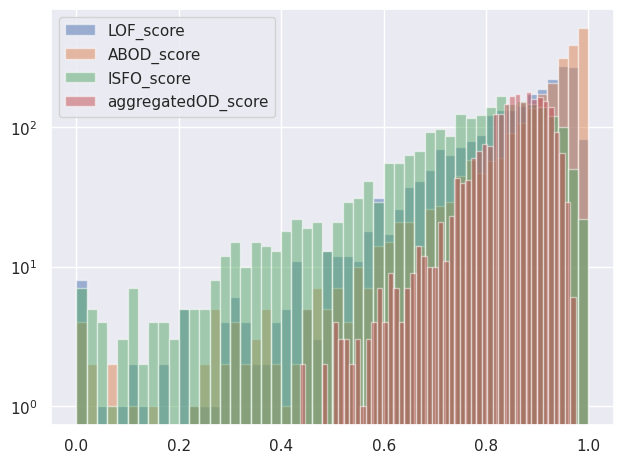

In [66]:
for col in [u for u in df_bag.columns if u.endswith("score")]:
    plt.hist(df_bag[col], bins=50, alpha=0.5, label=col);
plt.legend()
plt.yscale("log")

Distribution of the normalized scores for each method. It can be seen that ABOD categorizes many records as surely inliers (high peak near score=1) while ISFO is has much less certain inliers.
The aggregated score takes this uncertainty in account (almost no records in the high scoring region). Clearly, the minimum of the score is higher (about 0.4) since it is the min of the sum of non-negative entries.

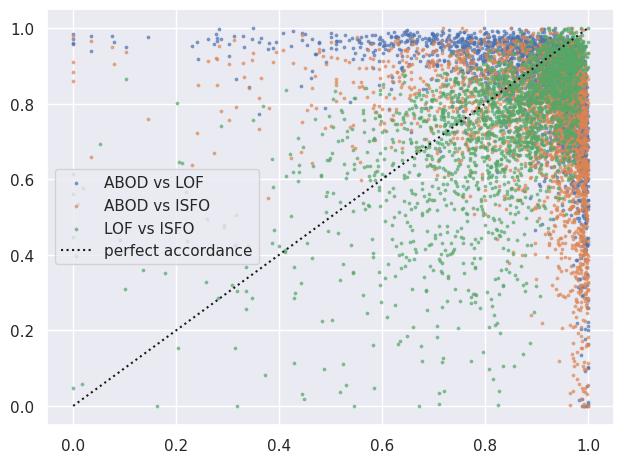

In [67]:
plt.scatter(df_bag["ABOD_score"], df_bag["LOF_score"],label="ABOD vs LOF", s=3, alpha=0.6)
plt.scatter(df_bag["ABOD_score"], df_bag["ISFO_score"],label="ABOD vs ISFO", s=3, alpha=0.6)
plt.scatter(df_bag["LOF_score"], df_bag["ISFO_score"],label="LOF vs ISFO", s=3, alpha=0.6)

plt.plot(np.linspace(0,1), np.linspace(0,1), ls=":", color="k", label="perfect accordance")
plt.legend()

Accordance between outliers. For perfect OD methods one would obtain only 0(outlier) and 1 (inlier) score values.

Since methods are uncertain, values are distributed. If each method was in perfect accordance with each other, scores would distribute around the bisecting line of the plane, since if one method categorizes a record to be an outlier (score near zero), other methods would give it a score near to zero too.

It can be seen that LOF and ISFO are in near accordance while ABOD is not in accordance with each other, since there are points in regions near (0, 1) (ABOD says outlier, LOF says inlier) and vice-versa.

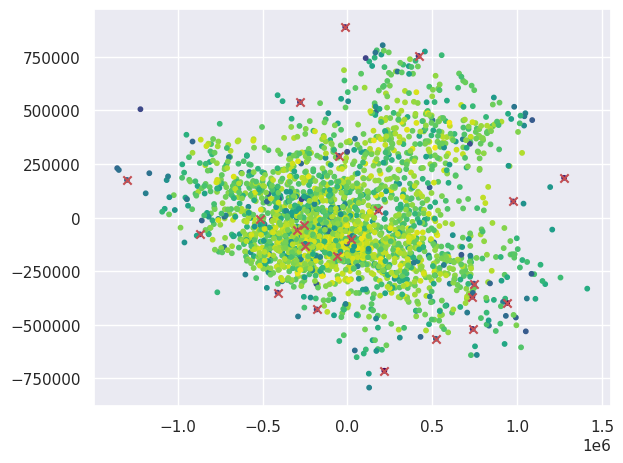

In [68]:
reducer = Isomap(n_components=2, n_neighbors=15)
X = reducer.fit_transform(df_bag[numerical_attr_list])
plt.scatter(X[:,0], X[:,1], c=df_bag.aggregatedOD_score, cmap="viridis", s=10)
mask = df_bag["is_aggregatedOD_outlier"]
plt.scatter(X[mask, 0], X[mask, 1], color="r", marker="x")

bluer means more outlier. red crosses are the chosen one percent of worst outliers

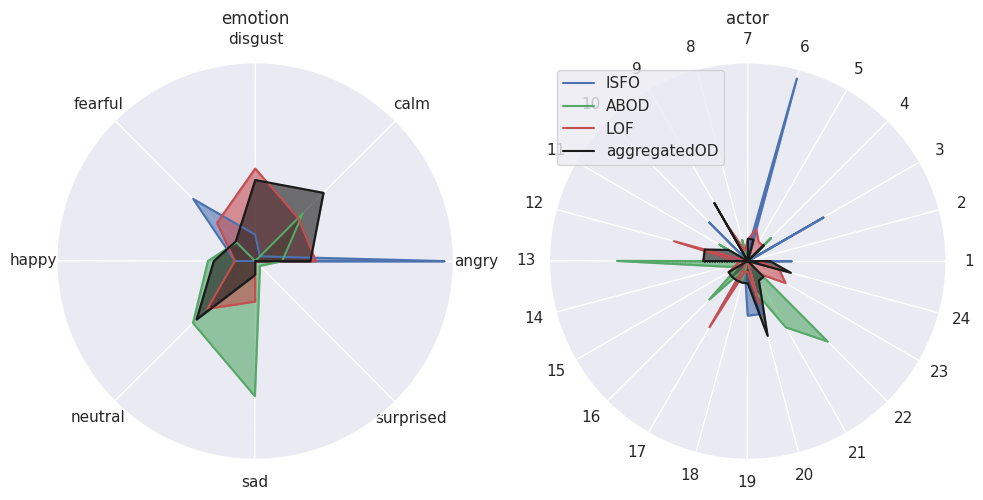

In [69]:
code_map = dict(not_outlier="k", ABOD="g", LOF="r", ISFO="b", aggregatedOD="k")

fig, axes = plt.subplots(1,2, figsize=(10,8), subplot_kw={'projection': 'polar'})
for i, cat in enumerate(["emotion", "actor"]):
    cat_vals, cat_counts = np.unique(df_bag[cat], return_counts=True)
    if cat =="actor":
        cat_vals = [int(act_name.split("_")[1]) for act_name in cat_vals]
    cat_counts = cat_counts/np.sum(cat_counts)

    for meth in outlier_detector.methods+[outlier_detector]:
        outlying_items, counts_num = np.unique(df_bag.loc[df_bag[f"is_{ meth.name}_outlier"], cat], return_counts=True)
        counts_num = counts_num/np.sum(counts_num)
        if cat == "actor":
            outlying_items = [int(act_name.split("_")[1]) for act_name in outlying_items]

        counts = {c:0 for c in np.unique(cat_vals)}
        for outlying_item, out_count, cc in zip(outlying_items, counts_num, cat_counts):
            # Normalize on category count
            # e.g.: More values of fear --> more outliers of fear
            counts[outlying_item] = out_count/cc

        plot_polar_closed(counts.keys(), counts.values(), axes[i], label=meth.name, color=code_map[meth.name])

axes[i].legend()
axes[0].set_title("emotion");
axes[1].set_title("actor");

Categories of outliers. Aggregated OD seems to have mitigate between each method, since it reaches a more equal distribution.

## Save results

In [70]:
df_bag = df_bag.reset_index(drop=True)
df_bag.to_csv(LABELLED_OUTLIERS, index=False)

# Reove outliers
df_outliers_removed = df_bag.loc[np.logical_not(df_bag.is_aggregatedOD_outlier)]
df_outliers_removed.to_csv(OUTLIERS_REMOVED, index=False)